In [25]:
import pandas as pd
import os
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
from sklearn.metrics.pairwise import paired_cosine_distances
import seaborn as sns

from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sacrebleu.metrics import BLEU
from scipy.stats import pearsonr

## Dataset

In [2]:
def load_dataset(lang):
    def remove_nan(df):
        res = df.dropna()
        return res, df.shape[0] - res.shape[0]
    
    train_df, train_miss = remove_nan(pd.read_csv(f"data/{lang}/train.csv"))
    test_df, test_miss = remove_nan(pd.read_csv(f"data/{lang}/test.csv"))
    all_miss = train_miss + test_miss
    if all_miss:
        print(f"W: {all_miss} rows with missing values")
        
    train_df = train_df[["Human" not in sysid for sysid in train_df.sysid]]
    test_df = test_df[["Human" not in sysid for sysid in test_df.sysid]]
    return train_df, test_df

In [3]:
def load_samples(lang, gold_column="segreference"):
    train_df, test_df = load_dataset(lang)
    
    # normalize scores to [0, 1]
    minimum = min(np.min(train_df.raw_score), np.min(test_df.raw_score))
    maximum = max(np.max(train_df.raw_score), np.max(test_df.raw_score))
    train_df["score"] = [(rs - minimum) / (maximum - minimum) for rs in train_df.raw_score]
    test_df["score"] = [(rs - minimum) / (maximum - minimum) for rs in test_df.raw_score]
    
    train_samples = []
    test_samples = []
    
    for df, samples in [(train_df, train_samples), (test_df, test_samples)]:
        for _, row in df.iterrows():
            input_example = InputExample(texts=[row[gold_column], row.segpredict], label=row.score)
            samples.append(input_example)
            
    return train_samples, test_samples

In [4]:
train_df, test_df = load_dataset("de")
train_df.head()

,setid,docid,origlang,trglang,segid,segsource,segreference,segpredict,sysid,raw_score,z_score
1,newstestB2020,independent.281139,en,de,1,Michael Jackson wore tape on his nose to get f...,"Ehemaliger Bodyguard behauptet, Michael Jackso...","Michael Jackson trug Klebeband auf der Nase, u...",Online-A.1574,100.0,0.487735
2,newstestB2020,independent.281139,en,de,1,Michael Jackson wore tape on his nose to get f...,"Ehemaliger Bodyguard behauptet, Michael Jackso...",Michael Jackson trug Klebeband auf seiner Nase...,Online-Z.1631,97.0,0.574869
3,newstestB2020,independent.281139,en,de,1,Michael Jackson wore tape on his nose to get f...,"Ehemaliger Bodyguard behauptet, Michael Jackso...","Michael Jackson trug Klebeband auf der Nase, u...",Tohoku-AIP-NTT.890,94.5,0.337131
4,newstestB2020,independent.281139,en,de,1,Michael Jackson wore tape on his nose to get f...,"Ehemaliger Bodyguard behauptet, Michael Jackso...","Michael Jackson trug Klebeband an der Nase, um...",PROMT_NMT.73,100.0,0.495619
6,newstestB2020,independent.281139,en,de,2,Michael Jackson's former bodyguard has claimed...,Michael Jacksons ehemaliger Bodyguard hat beha...,Michael Jacksons ehemaliger Leibwächter hat be...,Online-A.1574,91.0,0.118860


In [5]:
def compute_bleu_scores(df):
    bleu = BLEU(effective_order=True)
    df["bleu"] = [bleu.sentence_score(hyp, [ref]).score for (hyp, ref) in zip(df.segpredict, df.segreference)]

## Segment analysis

W: 4 rows with missing values


100%|███████████████████████████████████████████| 13984/13984 [00:06<00:00, 2095.61it/s]


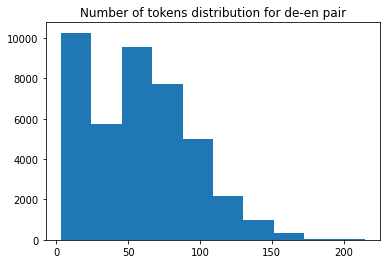

100%|███████████████████████████████████████████| 23865/23865 [00:09<00:00, 2505.17it/s]


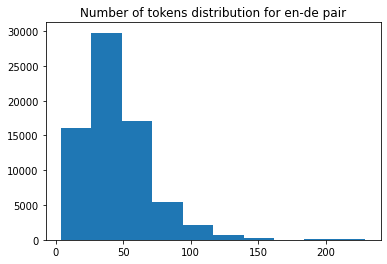

In [7]:
EN_PRETRAINED = "bert-base-uncased"
DE_PRETRAINED = "dbmdz/bert-base-german-uncased"

tokenizer_en = AutoTokenizer.from_pretrained(EN_PRETRAINED)
tokenizer_de = AutoTokenizer.from_pretrained(DE_PRETRAINED)

for lp, src_tokenizer, tgt_tokenizer in [
    ("de-en", tokenizer_de, tokenizer_en), ("en-de", tokenizer_en, tokenizer_de)
]:
    df, _ = load_dataset(lp[-2:])
    lens = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        lens.append(len(src_tokenizer(row.segsource)["input_ids"]))
        for column in ["segreference", "segpredict"]:
            lens.append(len(tgt_tokenizer(row[column])["input_ids"]))
    plt.title(f"Number of tokens distribution for {lp} pair")
    plt.hist(lens)
    plt.show()

## Sentence Transformer

In [8]:
def init_sentence_transformer(model_name, max_seq_length, is_sbert=False):
    if is_sbert:
        model = SentenceTransformer(model_name)
        model.max_seq_length = max_seq_length
        return model
    else:
        word_embedding_model = models.Transformer(MODEL_NAME, max_seq_length=max_seq_length)
        pooling_model = models.Pooling(768)
        return SentenceTransformer(modules=[word_embedding_model, pooling_model])
    

In [9]:
LANG = "en"
GOLD_COLUMN = "segsource"
MODEL_NAME = "distiluse-base-multilingual-cased-v1"
BATCH_SIZE = 16
NUM_EPOCHS = 5
MODEL_SAVE_PATH = (
    f"checkpoints/{LANG}-{GOLD_COLUMN}--" + MODEL_NAME + "--" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)

print(MODEL_SAVE_PATH)

checkpoints/en-segsource--distiluse-base-multilingual-cased-v1--2022-01-25_15-13-56


In [10]:
model = init_sentence_transformer(MODEL_NAME, max_seq_length=100, is_sbert=True)

In [11]:
train_samples, test_samples = load_samples(LANG, gold_column=GOLD_COLUMN)
train_loader = DataLoader(train_samples, shuffle=True, batch_size=BATCH_SIZE)
train_loss = losses.CosineSimilarityLoss(model=model)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name=f"{LANG}-{GOLD_COLUMN}-test")
warmup_steps = math.ceil(len(train_loader) * NUM_EPOCHS * 0.1)  # 10% of train data for warm-up

W: 4 rows with missing values


In [12]:
model.fit(
    train_objectives=[(train_loader, train_loss)],
    evaluator=evaluator,
    epochs=NUM_EPOCHS,
    evaluation_steps=500,
    warmup_steps=warmup_steps,
    output_path=MODEL_SAVE_PATH
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/874 [00:00<?, ?it/s]

Iteration:   0%|          | 0/874 [00:00<?, ?it/s]

Iteration:   0%|          | 0/874 [00:00<?, ?it/s]

Iteration:   0%|          | 0/874 [00:00<?, ?it/s]

Iteration:   0%|          | 0/874 [00:00<?, ?it/s]

In [13]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(train_samples, name=f"{LANG}-{GOLD_COLUMN}-train")
evaluator(model, output_path=MODEL_SAVE_PATH)

0.8159285297135916

## Write scores to CSV

In [39]:
def compute_cosine_scores(checkpoint, df, gold_column):
    model = SentenceTransformer(checkpoint)
    
    sentences1 = [s for s in df[gold_column]]
    sentences2 = [s for s in df["segpredict"]]
    
    embeddings1 = model.encode(sentences1, batch_size=BATCH_SIZE, convert_to_numpy=True)
    embeddings2 = model.encode(sentences2, batch_size=BATCH_SIZE, convert_to_numpy=True)
    
    del model
    
    return 1 - (paired_cosine_distances(embeddings1, embeddings2))

In [45]:
_, test_df = load_dataset("en")

cosine_scores_monolingual = compute_cosine_scores(
    "checkpoints/en-segreference--bert-base-uncased--2022-01-24_21-35-47", test_df, "segreference"
)
test_df["monolingual_bert_score"] = cosine_scores_monolingual.tolist()
cosine_scores_multilingual = compute_cosine_scores(
    "checkpoints/en-segsource--distiluse-base-multilingual-cased-v1--2022-01-25_15-13-56", test_df, "segsource"
)
test_df["multilingual_bert_score"] = cosine_scores_multilingual.tolist()

monolingual_pearson, _ = pearsonr(list(test_df.raw_score), cosine_scores_monolingual)
multilingual_pearson, _ = pearsonr(list(test_df.raw_score), cosine_scores_multilingual)

print("Mono:", monolingual_pearson)
print("Multi:", multilingual_pearson)

test_df.to_csv("data/en-test-scores.csv", index=False)

W: 4 rows with missing values
Mono: 0.7120178842535998
Multi: 0.6630953401637353


In [46]:
_, test_df = load_dataset("de")

cosine_scores_monolingual = compute_cosine_scores(
    "checkpoints/de-segreference--dbmdz/bert-base-german-uncased--2022-01-25_13-47-36", test_df, "segreference"
)
test_df["monolingual_bert_score"] = cosine_scores_monolingual.tolist()
cosine_scores_multilingual = compute_cosine_scores(
    "checkpoints/de-segsource--distiluse-base-multilingual-cased-v1--2022-01-25_14-41-39", test_df, "segsource"
)
test_df["multilingual_bert_score"] = cosine_scores_multilingual.tolist()

monolingual_pearson, _ = pearsonr(list(test_df.raw_score), cosine_scores_monolingual)
multilingual_pearson, _ = pearsonr(list(test_df.raw_score), cosine_scores_multilingual)

print("Mono:", monolingual_pearson)
print("Multi:", multilingual_pearson)

test_df.to_csv("data/de-test-scores.csv", index=False)

Mono: 0.4983872633439147
Multi: 0.3694785851691448
